<a href="https://colab.research.google.com/github/AmiraFaisal/Scenario2/blob/main/no_rewriter_Scenario_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[google doc](https://docs.google.com/document/d/1AJEu1s_ViChkY-IaLYIUC7Ia_XehJ62D9Er2ykEBsMs/edit?usp=drive_link)

# **1. Data Exploration and Preprocessing**

## **1.1 Load and explore**

### Set up libraries, reproducibility seed

In [ ]:
pip install wordcloud matplotlib langchain langchain-text-splitters chromadb datasets sentence-transformers transformers accelerate gradio --quiet

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import chromadb
import torch
import random
import traceback
import gradio as gr

In [ ]:
from wordcloud import WordCloud, STOPWORDS
from datetime import datetime
from pprint import pprint
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from langchain_text_splitters import RecursiveCharacterTextSplitter
from hashlib import md5
from datasets import Dataset, DatasetDict
from sklearn.metrics.pairwise import cosine_similarity
from transformers import(
    pipeline,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    GenerationConfig,
    EarlyStoppingCallback,
    AutoModelForSequenceClassification,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer)

In [ ]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(1)

### Data

In [ ]:
url = "https://raw.githubusercontent.com/AmiraFaisal/Scenario2/main/MedQuAD_Dataset_RAG_Scenario_2.csv"
df = pd.read_csv(url, header = 0)
df.head()

,question,answer,source,focus_area
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...",NIHSeniorHealth,Glaucoma
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...,NIHSeniorHealth,Glaucoma
3,What are the treatments for Glaucoma ?,"Although open-angle glaucoma cannot be cured, ...",NIHSeniorHealth,Glaucoma
4,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma


In [ ]:
def get_column_stats(dataframe):
    """Calculate Min, Max, and Average for all columns.
    Returns: DataFrame"""
    stats = {}

    for col in dataframe.columns:
        series = dataframe[col]

        if pd.api.types.is_numeric_dtype(series):
            # Numeric columns: calculate stats on the values
            stats[col] = {
                'Type': 'Numeric',
                'Min': series.min(),
                'Max': series.max(),
                'Average': series.mean(),
            }

        elif pd.api.types.is_string_dtype(series) or series.dtype == 'object':
            # String/Object columns: calculate stats on the string length
            lengths = series.astype(str).str.len()

            stats[col] = {
                'Type': 'String/Text',
                'Min Length': lengths.min(),
                'Max Length': lengths.max(),
                'Average Length': lengths.mean(),
            }

        else:
            stats[col] = {'Type': str(series.dtype), 'Note': 'Stats not calculated'}

    # Convert the results dictionary into a readable DataFrame
    return pd.DataFrame(stats).T.round(2)

# Run the function on the sample DataFrame
summary_df = get_column_stats(df)

print("-------------------- Column Stats Summary -------------------")
print(summary_df)
print("-------------------------------------------------------------")

-------------------- Column Stats Summary -------------------
                   Type Min Length Max Length Average Length
question    String/Text         16        191      50.684438
answer      String/Text          3      29046    1300.793992
source      String/Text          3         17       5.340239
focus_area  String/Text          3        136      26.225018
-------------------------------------------------------------


In [ ]:
def filterByLength(df: pd.DataFrame, column_name: str, min_length: int) -> pd.DataFrame:
    """Remove rows where column length is less than minimum threshold.
    Returns: DataFrame"""

    print(f"--- Filtering '{column_name}': Removing rows with length < {min_length} ---")

    # 1. Safely calculate the length of every cell (converting to string first)
    string_lengths = df[column_name].astype(str).str.len()

    # 2. Create a boolean mask: True where length is >= min_length
    complete_mask = string_lengths >= min_length

    # 3. Filter the DataFrame and return the result
    return df[complete_mask].copy() # Use .copy() to ensure a new DataFrame is returned


print(f"Original Row Count: {len(df)}")
# Clean the 'answer' and 'answer' columns with length under 20 words
df = filterByLength(
    df=df,
    column_name='question',
    min_length=20
)
print(f"Row Count after 'question' filter: {len(df)} \n")

df = filterByLength(
    df=df,
    column_name='answer',
    min_length=20
)
print(f"Row Count after 'answer' filter: {len(df)}")

Original Row Count: 16412
--- Filtering 'question': Removing rows with length < 20 ---
Row Count after 'question' filter: 16399 

--- Filtering 'answer': Removing rows with length < 20 ---
Row Count after 'answer' filter: 16356


### Downsampling `focus_area`

In [ ]:
# Unique 'focus_area's or Medical Topics
unique_focus_areas = df['focus_area'].astype(str).unique()
print(len(unique_focus_areas), "unique Focus Areas")

5124 unique Focus Areas


In [ ]:
focus_area_counts = df['focus_area'].value_counts()

In [ ]:
# Table summary of Focus area distribution
groups = pd.cut(focus_area_counts,
                bins = [0, 4, 9, 20, float('inf')],
                labels = ['<5', '5-9', '10 - 20', '>20'])
summary_focus_area = groups.value_counts().sort_index().to_frame(name = 'focus_area')
summary_focus_area['%'] = (summary_focus_area['focus_area'] / summary_focus_area['focus_area'].sum()) * 100
summary_focus_area['%'] = summary_focus_area['%'].map('{:.1f}%'. format)
summary_focus_area

,focus_area,%
count,,
<5,3388,66.1%
5-9,1585,30.9%
10 - 20,134,2.6%
>20,16,0.3%


In [ ]:
# Only use counts >10 and then top 1000 focus areas
above10counts_index = focus_area_counts[focus_area_counts > 10].index
above10counts = focus_area_counts[above10counts_index]
top1000 = above10counts.head(1000)

# cap at max 20 counts per focus area
new = pd.DataFrame()
for f_a in top1000.index:
    fa_df = df[df['focus_area'] == f_a]
    sample = fa_df.sample(n = min(20, len(fa_df)))
    new = pd.concat([new, sample])

print("Original df shape:", df.shape)
print("After cleaning   :", new.shape)
df = new.copy()

Original df shape: (16356, 4)
After cleaning   : (1406, 4)


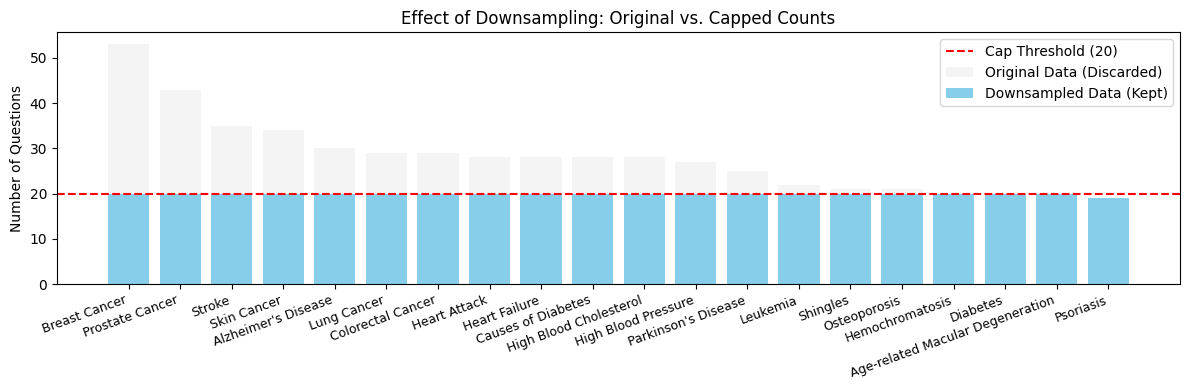

In [ ]:
sampled_counts = df['focus_area'].value_counts()

# Select top 20 focus areas from the ORIGINAL data to visualize
top_areas = focus_area_counts.head(20).index

# Align both datasets to these top 20
original_vals = focus_area_counts.loc[top_areas]
sampled_vals = sampled_counts.reindex(top_areas, fill_value=0)

plt.figure(figsize=(12, 4))

# Plot Original Data (The "Shadow")
plt.bar(top_areas, original_vals, color='gainsboro', alpha=0.3, label='Original Data (Discarded)')

# Plot Sampled Data (The "Result")
plt.bar(top_areas, sampled_vals, color='skyblue', alpha=1.0, label='Downsampled Data (Kept)')

plt.axhline(y=20, color='red', linestyle='--', label='Cap Threshold (20)')

plt.xticks(rotation=20, ha = 'right', fontsize = 9)
plt.title('Effect of Downsampling: Original vs. Capped Counts')
plt.ylabel('Number of Questions')
plt.legend()
plt.tight_layout()
plt.show()

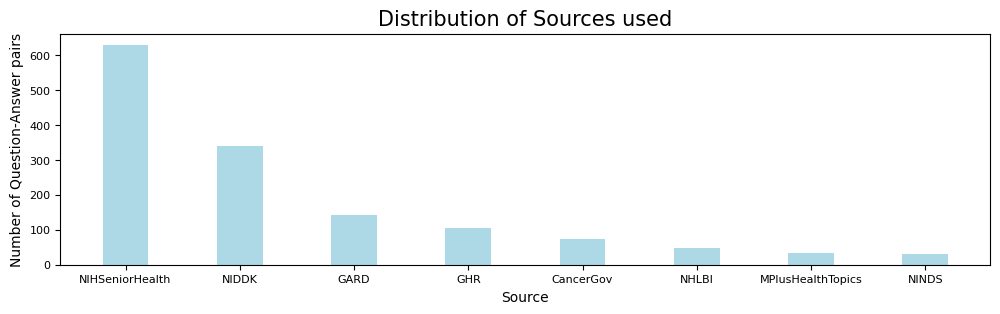

8 Sources used:  ['CancerGov', 'GARD', 'GHR', 'MPlusHealthTopics', 'NHLBI', 'NIDDK', 'NIHSeniorHealth', 'NINDS']


In [ ]:
# After downsampling
# Bar Chart
source_counts = df['source'].value_counts()

plt.figure(figsize=(12, 3))
plt.rcParams.update({'font.size': 8})
plt.bar(source_counts.index, source_counts.values, color='lightblue', width=0.4)
plt.xlabel("Source", fontsize=10)
plt.ylabel("Number of Question-Answer pairs", fontsize=10)
plt.title("Distribution of Sources used", fontsize=15)
plt.show()

# Unique 'source's
unique_sources = df['source'].unique()
print(len(unique_sources), "Sources used: ", sorted(unique_sources))

### Length Distributions

In [ ]:
word_count_question = df['question'].apply(lambda x: len(x.split(' ')) + 1)
word_count_answer = df['answer'].apply(lambda x: len(str(x).split(' ')) + 1)

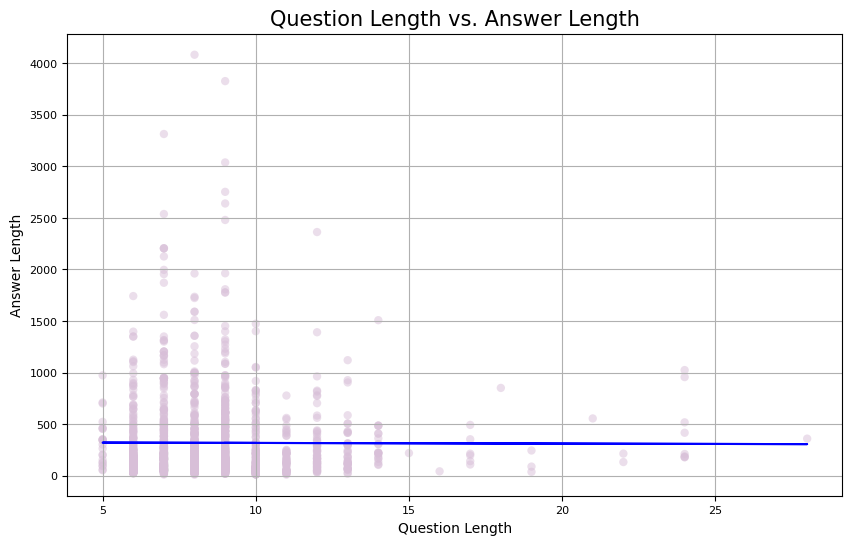

The gradient of the straight line is: -0.6444


In [ ]:
# QA correlation
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(word_count_question, word_count_answer, alpha=0.5, edgecolors='none', color='thistle')

# Calculate equation for trendline
z = np.polyfit(word_count_question, word_count_answer, 1)
p = np.poly1d(z)
ax.plot(word_count_question, p(word_count_question), color='blue')

ax.set_xlabel('Question Length', fontsize=10)
ax.set_ylabel('Answer Length', fontsize=10)
ax.set_title('Question Length vs. Answer Length', fontsize=15)

ax.grid(True)
plt.show()

z = np.polyfit(word_count_question, word_count_answer, 1)
print(f"The gradient of the straight line is: {z[0]:.4f}")

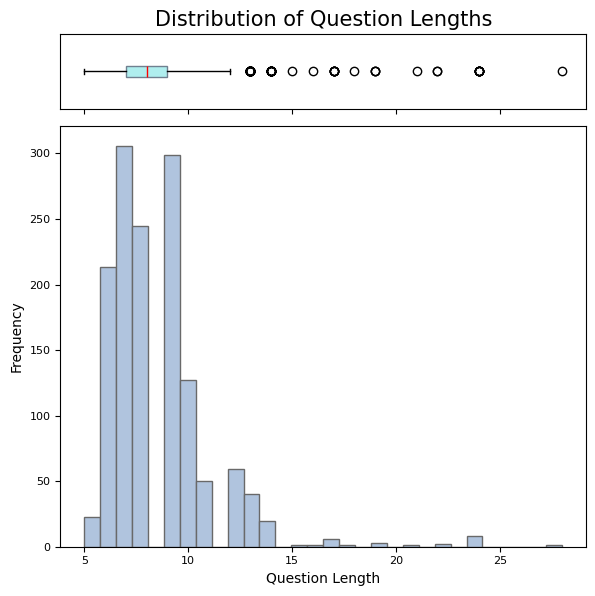

In [ ]:
# Question Lengths
# 1. Box plot
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(6, 6))

ax_box.boxplot(word_count_question, vert=False, patch_artist=True,
               boxprops=dict(facecolor='paleturquoise', color='slategray'),
               medianprops=dict(color='red'))
ax_box.set_ylabel('')
ax_box.set_yticks([])
ax_box.set_title('Distribution of Question Lengths', fontsize=15)

# 2. Histogram on the bottom subplot
ax_hist.hist(word_count_question, bins=30, color='lightsteelblue', edgecolor='dimgrey')
ax_hist.set_xlabel('Question Length', fontsize=10)
ax_hist.set_ylabel('Frequency', fontsize=10)

fig.tight_layout() # Remove extra space between subplots
ax_box.set(xlabel='') # Remove x axis name for the boxplot
plt.show()

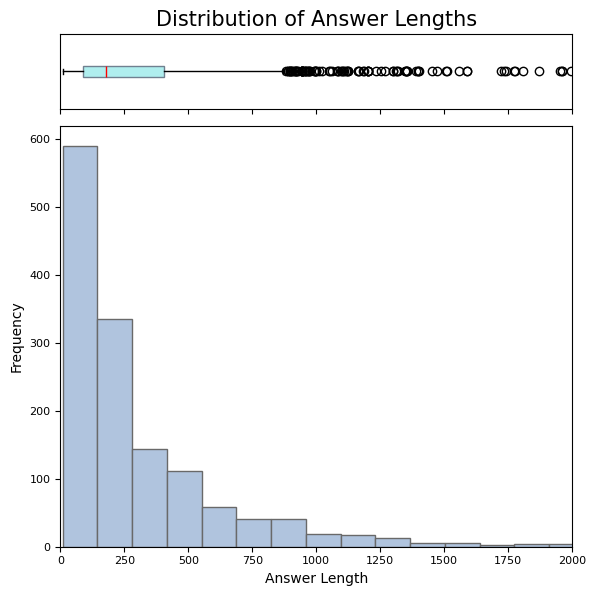

In [ ]:
# Answer Lengths
# 1. Box plot
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(6, 6))

ax_box.boxplot(word_count_answer, vert=False, patch_artist=True,
               boxprops=dict(facecolor='paleturquoise', color='slategray'),
               medianprops=dict(color='red'))
ax_box.set_ylabel('')
ax_box.set_yticks([])
ax_box.set_title('Distribution of Answer Lengths', fontsize=15)

# 2. Histogram on the bottom subplot
ax_hist.hist(word_count_answer, bins=30, color='lightsteelblue', edgecolor='dimgrey')
ax_hist.set_xlabel('Answer Length', fontsize=10)
ax_hist.set_ylabel('Frequency', fontsize=10)

ax_hist.set_xlim(0,2000)

fig.tight_layout() # Remove extra space between subplots
ax_box.set(xlabel='') # Remove x axis name for the boxplot
plt.show()

Every 1-word increase in *Question length*, increases *Answer length* by ~6.44 words.

## **1.2 Prepare the data**



### Duplicates - part 1

Set up needed functions

In [ ]:
def normalize_text(text):
    """Normalize text for duplicate detection by removing spaces and punctuation.
    Returns: str"""
    if not isinstance(text, str): return ""

    text = text.lower() # Lowercase
    text = re.sub(r'\s+', ' ', text) # Remove all extra whitespace (spaces, tabs, newlines)
    text = text.strip() # Remove leading/trailing spaces

    # Remove all punctuation
    text = re.sub(r'[^\w\s]', '', text)

    return text

def hashing(df):
    """Create hash for Q&A pairs to detect duplicates.
    Returns: DataFrame"""
    # Normalize for Q and A fields using earlier 'normalize_text' function
    q_norm = df['question'].apply(normalize_text)
    a_norm = df['answer'].apply(normalize_text)

    # Combine normalized Q&A
    qa_norm = q_norm + '|||' + a_norm

    # Create 16 digit hash
    df['qa_hash'] = qa_norm.apply(lambda x: md5(x.encode()).hexdigest())

    return df

def identify_duplicates(df):
    """Search for duplicate hashes in the dataframe.
    Returns: tuple (hashes, DataFrame)"""
    qa_hash = df['qa_hash']

    # Find which hashes appear more than once
    hash_counts = qa_hash.value_counts()
    d_hashes = hash_counts[hash_counts > 1].index

    print(f"Of {len(df)} pairs, {qa_hash.nunique()} unique hashes were created")
    print(f"Duplicate groups found: {len(d_hashes)}")
    print(f"Total duplicate pairs: {hash_counts[d_hashes].sum()}")

    # Create d_df to store duplicated pairs
    d_df = df[qa_hash.isin(d_hashes)].copy()

    # Group duplicates using ids
    hash_groups = {hash_val: i for i, hash_val in enumerate(d_hashes)}
    d_df['duplicate group'] = d_df['qa_hash'].map(hash_groups)
    d_df = d_df.sort_values('duplicate group')

    return d_hashes, d_df

def remove_duplicates(df):
    """Remove duplicate Q&A pairs from dataframe.
    Returns: tuple (clean_df, duplicates_df)"""
    d_hashes, d_df = identify_duplicates(df)

    # Remove duplicates
    clean_df = df.drop_duplicates(subset = 'qa_hash', keep = 'first').copy()

    # Remove temporary fields
    clean_df = clean_df.drop(['qa_hash'], axis=1)
    d_df = d_df.drop(['qa_hash'], axis=1)

    print(f"After removing duplicates: {len(clean_df)} pairs")
    print(f"Removed: {len(df) - len(clean_df)} pairs\n")

    return clean_df, d_df

def truncate(text, length_limit):
    """Truncate text to specified character limit.
    Returns: str"""
    return f"{text[:length_limit]}{'...' if len(text) > length_limit else ''}"

def show_duplicates(df, max_groups = 10):
    """Display grouped duplicate Q&A pairs.
    Returns: None"""
    clean_df, d_df = remove_duplicates(df)

    if d_df is None:
        print("No duplicates found")
        return
    d_groups = d_df.groupby('duplicate group')
    print(f"{' '*21} Showing {max_groups} duplicate groups")
    d_pairs = list(d_groups)[:max_groups]
    for i, g in d_pairs:
        print(f"{'='*70}")
        print(f"{' '*22} GROUP {i+1} with {len(g)} occurrences")
        print(f"{'='*70}")

        p_ids = []
        for index, (pair_idx, pair) in enumerate(g.iterrows(),1):
            p_ids.append(f"Row {pair_idx}")
        print(", ". join(p_ids))

        pair = g.iloc[0]
        print("The duplicated QA pair")
        print(f"    Question: {truncate(pair['question'], 100)}")
        print(f"    Answer  : {truncate(pair['answer'], 60)}")
        print(f"    Focus Area: {pair['focus_area']}")

### Duplicates - part 2

duplicates in answer field

In [ ]:
# Hash Q&A pairs
df = hashing(df)

# Review found duplicates
show_duplicates(df, max_groups = 10)

Of 1406 pairs, 1377 unique hashes were created
Duplicate groups found: 20
Total duplicate pairs: 49
After removing duplicates: 1377 pairs
Removed: 29 pairs

                      Showing 10 duplicate groups
                       GROUP 1 with 7 occurrences
Row 16020, Row 16210, Row 16209, Row 15347, Row 16019, Row 15248, Row 15346
The duplicated QA pair
    Question: What causes Causes of Diabetes ?
    Answer  : Other types of diabetes have a variety of possible causes.
 ...
    Focus Area: Causes of Diabetes
                       GROUP 2 with 4 occurrences
Row 15249, Row 16021, Row 15348, Row 16211
The duplicated QA pair
    Question: What to do for Causes of Diabetes ?
    Answer  : - Diabetes is a complex group of diseases with a variety of ...
    Focus Area: Causes of Diabetes
                       GROUP 3 with 3 occurrences
Row 15244, Row 16206, Row 15343
The duplicated QA pair
    Question: What causes Causes of Diabetes ?
    Answer  : Type 1 diabetes is caused by a lack of 

In [ ]:
# Remove duplicates
clean_df, d_df = remove_duplicates(df)

Of 1406 pairs, 1377 unique hashes were created
Duplicate groups found: 20
Total duplicate pairs: 49
After removing duplicates: 1377 pairs
Removed: 29 pairs



In [ ]:
# Check for exact duplicates for 'questions'
duplicates = clean_df[clean_df.duplicated(subset=['question'], keep=False)]
print(f"Found {len(duplicates)} rows with duplicate questions")
print(duplicates[['question', 'focus_area', 'source']].head(10))

# Remove duplicates before splitting
df_deduped = clean_df.drop_duplicates(subset=['question'], keep='first')
print(f"Removed {len(clean_df) - len(df_deduped)} duplicate questions")

Found 1008 rows with duplicate questions
                                               question     focus_area  \
771            What are the symptoms of Breast Cancer ?  Breast Cancer   
382                 Who is at risk for Breast Cancer? ?  Breast Cancer   
1165  what research (or clinical trials) is being do...  Breast Cancer   
772                     How to diagnose Breast Cancer ?  Breast Cancer   
1160           What are the symptoms of Breast Cancer ?  Breast Cancer   
775         What are the treatments for Breast Cancer ?  Breast Cancer   
399   what research (or clinical trials) is being do...  Breast Cancer   
390                 Who is at risk for Breast Cancer? ?  Breast Cancer   
383                     How to diagnose Breast Cancer ?  Breast Cancer   
401         What are the treatments for Breast Cancer ?  Breast Cancer   

               source  
771         CancerGov  
382   NIHSeniorHealth  
1165        CancerGov  
772         CancerGov  
1160        CancerGov  


In [ ]:
df = df_deduped
# Reset index
df = df.reset_index(drop=True)

In [ ]:
# Check for exact duplicates for 'questions'
duplicates = df[df.duplicated(subset=['question'], keep=False)]
print(f"Found {len(duplicates)} rows with duplicate questions")
print(duplicates[['question', 'focus_area', 'source']].head(10))

Found 0 rows with duplicate questions
Empty DataFrame
Columns: [question, focus_area, source]
Index: []


One of the primary advantages of using cryptographic hashing in data deduplication is its ability to quickly determine unique data segments. By generating a hash for each piece of data, systems can compare hash values rather than the actual data. If two data segments produce the same hash, they can be identified as duplicates. This method significantly reduces the time and resources required for data comparison, as comparing hash values is computationally less intensive than comparing full data sets.

### Clean `answer` field

In [ ]:
def clean_references(text):
    """Remove references, contact info, irrelevant sentences, and unnecessary punctuation.
    Keep only periods, commas, apostrophes, and question marks.
    Returns: str(cleaned_text)"""
    if not isinstance(text, str):
        return ""

    # lowercasing
    text = text.lower()

    phone_pattern = r'\b\d{3}-\d{3}-\d{4}\b|\b\d{3}-\d{2}-\d{4}\b|\b1-\d{3}-\d{3}-\d{4}\b|\b\d{4}-\d{3}-\d{4}\b|\bToll Free:.*?\b'
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    address_pattern = r'\d+\s+[A-Za-z\s]+,\s*[A-Za-z\s]+,\s*[A-Z]{2}\s*\d{5}(-\d{4})?'

    # remove patterns
    text = re.sub(phone_pattern, '', text, flags=re.IGNORECASE)
    text = re.sub(email_pattern, '', text)
    text = re.sub(url_pattern, '', text)
    text = re.sub(address_pattern, '', text)

    irrelevant_keywords = ['toll free', 'phone', 'email',
                    'fax', 'tty', 'clearinghouse',
                    'esc', 'keyboard', 'video',
                    'for more information', 'glossary',
                    'learn more', 'www', 'click', 'visit',
                    'call' ]

    # Split by sentence-ending punctuation followed by space
    sentences = re.split(r'(?<=[.!?])\s+', text)

    # if sentence has no irrelevant_keywords, then save to cleaned_sentences
    cleaned_sentences = [s for s in sentences if not any(keyword in s.lower() for keyword in irrelevant_keywords)]

    # Smart join: only add '. ' if previous sentence doesn't already end with punctuation
    cleaned_text = ""
    for i, sentence in enumerate(cleaned_sentences):
        if i == 0:
            cleaned_text = sentence
        else:
            # Only add '. ' if the previous part doesn't end with . or ?
            if cleaned_text and not cleaned_text.endswith(('.', '?')):
                cleaned_text += '. '
            else:
                cleaned_text += ' '
            cleaned_text += sentence

    cleaned_text = cleaned_text.strip()

    # Replace whitespace characters with a single space
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)

    # If sentence starts with . then remove the .
    cleaned_text = re.sub(r'^\s*\.\s*', '', cleaned_text)

    # Keep ONLY periods, commas, apostrophes, question marks - remove ALL other punctuation
    allowed_punct = {'.', ',', "'", '?'}
    text_minimal_punct = ""
    for char in cleaned_text:
        if char.isalnum() or char.isspace() or char in allowed_punct:
            text_minimal_punct += char

    # Clean up spacing again after punctuation removal
    cleaned_text = ' '.join(text_minimal_punct.split()).strip()

    # Ensure text ends with period only if it doesn't already end with . or ?
    if cleaned_text and not cleaned_text.endswith(('.', '?')):
        cleaned_text += '.'

    return cleaned_text

df_answer = df['answer'].apply(clean_references)

In [ ]:
print("Before: ", df['answer'][510])
print("After: ", df_answer[510])
df['answer'] = df_answer
# Remove rows where the answer field is empty or only whitespace
df = df[df['answer'].str.strip() != '']

# Reset index
df = df.reset_index(drop=True)

Before:  How is Danon disease inherited? Dannon disease is inherited in an X-linked fashion. Click here to visit the Centre for Genetics Education Web site to learn more about X linked inheritance.
After:  how is danon disease inherited? dannon disease is inherited in an xlinked fashion.


In [ ]:
df.shape

(709, 4)

In [ ]:
# After cleaning, Run the function on the sample DataFrame
summary_df = get_column_stats(df)

print("---------------- Column Stats Summary ----------------")
print(summary_df)
print("------------------------------------------------------")

---------------- Column Stats Summary ----------------
                   Type Min Length Max Length Average Length
question    String/Text         20        191      43.953456
answer      String/Text         40      13868    1493.942172
source      String/Text          3         17       8.375176
focus_area  String/Text          4        136      20.191819
------------------------------------------------------


### Split datasets for fine-tuning and testing

to be then train and validate the LLM

In [ ]:
from sklearn.model_selection import GroupShuffleSplit

# 1. Outer Split: Train (70%) vs Val+Test (30%)
gss_outer = GroupShuffleSplit(n_splits=1, test_size = 0.30, random_state = 1)
train_idx, valtest_idx = next(gss_outer.split(df, groups = df['question']))

train_data = df.iloc[train_idx].copy()
valtest_df = df.iloc[valtest_idx].copy()

# 2. Inner Split: Val (20%) vs Test (10%)
gss_inner = GroupShuffleSplit(n_splits = 1, test_size=1/3, random_state=  1)
val_idx, test_idx = next(gss_inner.split(valtest_df, groups=valtest_df['question']))

val_data = valtest_df.iloc[val_idx].copy()
test_data = valtest_df.iloc[test_idx].copy()

# Check sizes
print(f"Train size: {len(train_data)}")
print(f"Val size:   {len(val_data)}")
print(f"Test size:  {len(test_data)}")

# Check for Leakage
train_qs = set(train_data['question'])
test_qs = set(test_data['question'])
overlap = train_qs.intersection(test_qs)
print(f"Question Leakage: {len(overlap)} (should be 0)")

Train size: 496
Val size:   142
Test size:  71
Question Leakage: 0 (should be 0)


In [ ]:
print("------------------------------ Check for Data Leakage -----------------------------")
# 1. ID / Source Leakage
train_ids = set(train_data['question_id']) if 'question_id' in train_data else set(train_data.index)
test_ids = set(test_data['question_id']) if 'question_id' in test_data else set(test_data.index)

id_overlap = train_ids.intersection(test_ids)
print(f"1. ID Overlap: {len(id_overlap)} IDs found in both sets.")
if len(id_overlap) > 0:
    print(f"   CRITICAL: Remove IDs {list(id_overlap)[:5]}...")

# 2. Look for questions in Test that are  copies of questions in Train
train_questions = set(train_data['question'].str.lower().str.strip())
test_questions = set(test_data['question'].str.lower().str.strip())

q_overlap = train_questions.intersection(test_questions)

print(f"\n2. Question Text Overlap: {len(q_overlap)} unique questions found in both sets.")
print(f"   Test Set Size: {len(test_questions)} unique questions")

leakage_pct = len(q_overlap) / len(test_questions) * 100
print(f"   {leakage_pct:.1f}% of your Test Set questions are repeats of Training questions.")

if len(q_overlap) > 0:
    print(f"   Example: '{list(q_overlap)[0]}'")

# 3. Check if the Test Answer text exists inside the Training Question OR Answer columns
train_answers = set(train_data['answer'].str.lower().str.strip())
test_answers = set(test_data['answer'].str.lower().str.strip())

a_overlap = train_answers.intersection(test_answers)
print(f"\n3. Answer Text Overlap: {len(a_overlap)} exact answers found in both sets.")

if len(a_overlap) > 0:
    print("   Test set contains answers that are identical to Training answers.")
    print("   The model might just retrieve the text rather than generating it.")
print("-----------------------------------------------------------------------------------")

------------------------------ Check for Data Leakage -----------------------------
1. ID Overlap: 0 IDs found in both sets.

2. Question Text Overlap: 0 unique questions found in both sets.
   Test Set Size: 71 unique questions
   0.0% of your Test Set questions are repeats of Training questions.

3. Answer Text Overlap: 3 exact answers found in both sets.
   Test set contains answers that are identical to Training answers.
   The model might just retrieve the text rather than generating it.
-----------------------------------------------------------------------------------


In [ ]:
for a in a_overlap:print(a, "\n")

this condition is inherited in an autosomal recessive pattern, which means both copies of the gene in each cell have mutations. 

new types of treatment are being tested in clinical trials. information about clinical trials is available from the nci website. patients may want to think about taking part in a clinical trial. for some patients, taking part in a clinical trial may be the best treatment choice. clinical trials are part of the cancer research process. clinical trials are done to find out if new cancer treatments are safe and effective or better than the standard treatment. many of today's standard treatments for cancer are based on earlier clinical trials. patients who take part in a clinical trial may receive the standard treatment or be among the first to receive a new treatment. patients who take part in clinical trials also help improve the way cancer will be treated in the future. even when clinical trials do not lead to effective new treatments, they often answer impor

In [ ]:
print(f"Original Test Data size: {len(test_data)} rows")

test_answers_normalized = test_data['answer'].str.lower().str.strip()
test_df_cleaned = test_data[~test_answers_normalized.isin(a_overlap)].copy()
test_data = test_df_cleaned

print(f"Test Data size after removing answer overlap: {len(test_data)} rows")

print("\n------------------------------ Re-run Data Leakage Check -----------------------------")
test_questions = set(test_data['question'].str.lower().str.strip())
test_answers = set(test_data['answer'].str.lower().str.strip())

q_overlap = train_questions.intersection(test_questions)
a_overlap_cleaned = train_answers.intersection(test_answers)

print(f"1. Question Text Overlap: {len(q_overlap)} unique questions found in both sets.")
print(f"   Test Set Size: {len(test_questions)} unique questions")
leakage_q_pct = len(q_overlap) / len(test_questions) * 100
print(f"   {leakage_q_pct:.1f}% of your Test Set questions are repeats of Training questions.")

print(f"\n2. Answer Text Overlap (after cleaning): {len(a_overlap_cleaned)} exact answers found in both sets.")
if len(a_overlap_cleaned) == 0:
    print("   No exact answer overlaps remaining.")
else:
    print("   Still some overlaps")
print("-----------------------------------------------------------------------------------")

Original Test Data size: 71 rows
Test Data size after removing answer overlap: 68 rows

------------------------------ Re-run Data Leakage Check -----------------------------
1. Question Text Overlap: 0 unique questions found in both sets.
   Test Set Size: 68 unique questions
   0.0% of your Test Set questions are repeats of Training questions.

2. Answer Text Overlap (after cleaning): 0 exact answers found in both sets.
   No exact answer overlaps remaining.
-----------------------------------------------------------------------------------


In [ ]:
# Get unique Focus Areas for each split
train_areas = set(train_data['focus_area'].unique())
val_areas = set(val_data['focus_area'].unique())
test_areas = set(test_data['focus_area'].unique())

# Print detailed statistics
print("-----------------focus_area overlap analysis-----------------")
print(f"Unique areas in Train: {len(train_areas)}")
print(f"Unique areas in Val:   {len(val_areas)}")
print(f"Unique areas in Test:  {len(test_areas)}")

common_to_all = train_areas.intersection(val_areas).intersection(test_areas)
print(f"\nAreas common to ALL THREE splits: {len(common_to_all)}")

missing_from_test = train_areas - test_areas
if len(missing_from_test) == 0:
    print("Every topic in Train is also in Test, which is wrong")
else:
    print(f"{len(missing_from_test)} topics in Train are missing from Test, which is fine")
    train_only = train_areas - test_areas
    if len(train_only) > 0:
        print("Missing Examples:", list(train_only)[:5])
    print()
unique_to_test = test_areas - train_areas - val_areas
if len(unique_to_test) > 0:print(f"{len(unique_to_test)} topics appear ONLY in Test")
print("-------------------------------------------------------------")

-----------------focus_area overlap analysis-----------------
Unique areas in Train: 102
Unique areas in Val:   80
Unique areas in Test:  51

Areas common to ALL THREE splits: 41
51 topics in Train are missing from Test, which is fine
Missing Examples: ['Kidney Disease', 'Surviving Cancer', 'Stroke', 'Age-related Macular Degeneration', 'Narcolepsy']

-------------------------------------------------------------


### Create chunks

In [ ]:
# Calculate actual token counts
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")
question_tokens = [len(tokenizer.encode(q)) for q in train_data['question']]
answer_tokens = [len(tokenizer.encode(a)) for a in train_data['answer'] ]

combined_tokens = [q + a for q, a in zip(question_tokens, answer_tokens)]

print("For Train data")
print(f"Avg question tokens: {sum(question_tokens)/len(question_tokens)}")
print(f"Avg answer tokens: {sum(answer_tokens)/len(answer_tokens)}")
print(f"Avg combined tokens: {sum(combined_tokens)/len(combined_tokens)}")
print(f"95th percentile answer tokens: {sorted(answer_tokens)[int(len(answer_tokens)*0.95)]}")

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (694 > 512). Running this sequence through the model will result in indexing errors


For Train data
Avg question tokens: 13.75
Avg answer tokens: 341.59879032258067
Avg combined tokens: 355.34879032258067
95th percentile answer tokens: 1068


In [ ]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size=350,
    chunk_overlap=50,
    length_function=lambda x: len(tokenizer.encode(x)),
)

# Get the longest answers by character length
longest_answers_train = train_data.assign(answer_len=train_data['answer'].str.len()).nlargest(3, 'answer_len')['answer'].tolist()
longest_answers_val = val_data.assign(answer_len=val_data['answer'].str.len()).nlargest(3, 'answer_len')['answer'].tolist()
longest_answers_test = test_data.assign(answer_len=test_data['answer'].str.len()).nlargest(3, 'answer_len')['answer'].tolist()

test_answers = longest_answers_train + longest_answers_val + longest_answers_test

token_lengths = []
for answer in test_answers:
    chunks = splitter.split_text(answer)
    for chunk in chunks:
        tokens = len(tokenizer.encode(chunk))
        token_lengths.append(tokens)
print(f"Total Chunks: {len(token_lengths)}")
print(f"Shortest Chunk: {min(token_lengths)} tokens")
print(f"Longest Chunk: {max(token_lengths)} tokens")
print(f"Average length: {sum(token_lengths)/len(token_lengths)}")
sorted_n = sorted(token_lengths)
n = len(sorted_n)
mid = n // 2
if n%2 == 0: print(f"Median length: {sorted_n[mid - 1]+sorted_n[mid]/2}")
else: print(f"Median length: {sorted_n[mid]}")

Total Chunks: 158
Shortest Chunk: 42 tokens
Longest Chunk: 194 tokens
Average length: 140.9367088607595
Median length: 211.5


In [ ]:
def create_chunks(dataframe, split_subset, start_counter):
    """Split dataframe into chunks with sequential IDs.
    Returns: tuple (chunks_list, counter)"""
    local_chunks = []
    current_counter = start_counter
    for i, row in dataframe.iterrows():
        answer_text = row['answer']
        q, a_sliced, focus, source = row['question'], answer_text, row['focus_area'], row['source']
        chunks = splitter.split_text(a_sliced)

        for chunk_local_id, chunk in enumerate(chunks):
            local_chunks.append({
                'question_id': current_counter,                    # New sequential ID
                'chunk_id': f"{current_counter}_{chunk_local_id}", # Unique ID based on new sequential ID
                'question': q,                                     # Original question
                'chunk_answer': chunk,                             # The actual split text
                'focus_area': focus,
                'source': source,
                'split_subset': split_subset                       # Add split subset information
            })
        current_counter += 1            # Increment the counter after processing all chunks for a question
    return local_chunks, current_counter


current_question_id_counter = 0

train_chunks, current_question_id_counter = create_chunks(train_data, 'train', current_question_id_counter)
val_chunks, current_question_id_counter = create_chunks(val_data, 'val', current_question_id_counter)
test_chunks, current_question_id_counter = create_chunks(test_data, 'test', current_question_id_counter)

print(f"Total chunks created: {len(train_chunks)}")
print(f"Total unique question_ids: {current_question_id_counter}")

Total chunks created: 1538
Total unique question_ids: 706


### Create embeddings on `train_data`

convert each chunk into dense vector embeddings using `SentenceTransformer` model

In [ ]:
qa_pairs = []

for chunk_item in train_chunks:
    question = chunk_item.get('question', '')
    chunk_answer = chunk_item.get('chunk_answer', '')

    # Embedding qa_pairs
    qa_pairs.append(f"{question} {chunk_answer}")

embed_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Create embeddings
embeddings = embed_model.encode(
    qa_pairs,
    batch_size = 64,
    show_progress_bar = True,
    convert_to_numpy = True,
    normalize_embeddings = True
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

### Chromadb vector store for `train_data`

In [ ]:
# Initialize ChromaDB
db_client = chromadb.PersistentClient(path="./MedQuAD_db")

# In case of duplicates from re-runs
try:
    db_client.delete_collection("medical_rag")
except:
    pass

vector_store = db_client.create_collection(name="medical_rag")

# Add to ChromaDB
vector_store.add(
    ids = [m['chunk_id'] for m in train_chunks],  # Use chunk_id as primary key
    embeddings = embeddings.tolist(),
    documents = qa_pairs,
    metadatas = train_chunks                      # Previously defined
)

In [ ]:
print("=" * 33, "qa_pairs[0]", "=" * 33)
pprint.pprint(qa_pairs[0])
print("\n", "=" * 31, "train_chunks[0]", "=" * 31)
pprint.pprint(train_chunks[0])
print("\n", "=" * 23, "vector_store.get(ids = ['0_0'])", "=" * 24)
vector_store.get(ids = ['0_0'])

================================= qa_pairs[0] =================================
('What are the symptoms of Breast Cancer ? signs of breast cancer include a '
 'lump or change in the breast. these and other signs may be caused by breast '
 'cancer or by other conditions. check with your doctor if you have any of the '
 'following a lump or thickening in or near the breast or in the underarm '
 'area. a change in the size or shape of the breast. a dimple or puckering in '
 'the skin of the breast. a nipple turned inward into the breast. fluid, other '
 "than breast milk, from the nipple, especially if it's bloody. scaly, red, or "
 'swollen skin on the breast, nipple, or')

 =============================== train_chunks[0] ===============================
{'chunk_answer': 'signs of breast cancer include a lump or change in the '
                 'breast. these and other signs may be caused by breast cancer '
                 'or by other conditions. check with your doctor if you have '
   

{'ids': ['0_0'],
 'embeddings': None,
 'documents': ["What are the symptoms of Breast Cancer ? signs of breast cancer include a lump or change in the breast. these and other signs may be caused by breast cancer or by other conditions. check with your doctor if you have any of the following a lump or thickening in or near the breast or in the underarm area. a change in the size or shape of the breast. a dimple or puckering in the skin of the breast. a nipple turned inward into the breast. fluid, other than breast milk, from the nipple, especially if it's bloody. scaly, red, or swollen skin on the breast, nipple, or"],
 'uris': None,
 'included': ['metadatas', 'documents'],
 'data': None,
 'metadatas': [{'chunk_id': '0_0',
   'source': 'CancerGov',
   'question_id': 0,
   'focus_area': 'Breast Cancer',
   'question': 'What are the symptoms of Breast Cancer ?',
   'split_subset': 'train',
   'chunk_answer': "signs of breast cancer include a lump or change in the breast. these and other si

In [ ]:
# Query ChromaDB
results = vector_store.query(
    query_texts = ["What is (are) Glaucoma ?"],
    n_results = 5
)

# Check id consistency
for i, (chunk_id, m) in enumerate(zip(results['ids'][0], results['metadatas'][0])):
    print(f"Result {i}:")
    print(f"  chunk_id: {chunk_id}")
    print(f"  question_id: {m['question_id']}")
    print(f"  question: {m['question']}")
    print(f"  split: {m['split_subset']}")
    print(f"  Can trace back: question_id {m['question_id']} → original train_data row\n")

/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:01<00:00, 56.8MiB/s]


Result 0:
  chunk_id: 137_1
  question_id: 137
  question: What causes Glaucoma ?
  split: train
  Can trace back: question_id 137 → original train_data row

Result 1:
  chunk_id: 135_1
  question_id: 135
  question: What are the treatments for Glaucoma ?
  split: train
  Can trace back: question_id 135 → original train_data row

Result 2:
  chunk_id: 137_0
  question_id: 137
  question: What causes Glaucoma ?
  split: train
  Can trace back: question_id 137 → original train_data row

Result 3:
  chunk_id: 135_0
  question_id: 135
  question: What are the treatments for Glaucoma ?
  split: train
  Can trace back: question_id 135 → original train_data row

Result 4:
  chunk_id: 135_2
  question_id: 135
  question: What are the treatments for Glaucoma ?
  split: train
  Can trace back: question_id 135 → original train_data row



# **2. Implement a Retrieval-Augmented Generation (RAG):**

## **2.1 Retriever**

### Rewrite query

Below is an instruction that describes a task, paired with an inpu that provides further context. Write a response that appropriately completes the request. Instruction: {You are a helpful medical practitioner}
Input:
{}
Response:
{}

In [ ]:
rewritter_llm = pipeline(
    "text2text-generation",
    model = "google/flan-t5-small",
    max_length = 64,
    do_sample = False,        # always chooses the most probable next word or token
    temperature = 0.3,        # more straightforward and predictable output
    repetition_penalty = 1.3, # minimize repetition and have a more varied output
    no_repeat_ngram_size = 2)

def rewrite_query(user_query):
    """Rewrite user query to be more specific and medical-focused.
    Returns: str"""

    # few shot prompting
    prompt = f"""Rewrite the input into a clear medical question following these patterns
    Input: my head hurts
    Output: What causes headaches?

    Input: i keep vomiting but feel ok afterwards
    Output: What causes cyclic vomiting?

    Input: chest pain when breathing
    Output: What causes chest pain during breathing?

    Input: {user_query}
    Output:
    """

    llm_output = rewritter_llm(prompt)

    rewritten_query = llm_output[0]['generated_text']
    rewritten_query = rewritten_query.replace("Output:", "").strip()

    return rewritten_query.strip()

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Device set to use cpu
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [ ]:
# test
user_query = "What are the symptoms of Cyclic Vomiting Syndrome ?"
rewritten_query = rewrite_query(user_query)

print(f"Original: {user_query}")
print(f"Rewritten: {rewritten_query}")

Original: What are the symptoms of Cyclic Vomiting Syndrome ?
Rewritten: What are the symptoms of Cyclic Vomiting Syndrome?


### Re-rank Contexts

In [ ]:
rerank_tokenizer = AutoTokenizer.from_pretrained("castorini/monot5-base-msmarco")
rerank_model = AutoModelForSeq2SeqLM.from_pretrained("castorini/monot5-base-msmarco")
rerank_model.eval() # Set to evaluation mode, w/o training

tokenizer_config.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [ ]:
def getMonoT5Scores(rewritten_query, chunks):
  """Calculate relevance scores for chunks against query.
  Returns: list"""
  # 1. Format the input "Query: ABC? Document: XYZ... Relevant: "
  inputs = [f"Query: {rewritten_query} Document: {c} Relevant:" for c in chunks]

  # 2. Tokenise
  tokenized_inputs = rerank_tokenizer(
      inputs,
      padding = True,
      truncation = True,      # Cut off if chunk is too long
      return_tensors = 'pt')  # Return as PyTorch tensors

  # 2. Generate predictions either True / False
  with torch.no_grad():                                       # w/o calculating gradients, and faster
    outputs = rerank_model.generate(
        input_ids = tokenized_inputs['input_ids'],
        attention_mask = tokenized_inputs['attention_mask'],
        max_new_tokens = 1,                                   # Only generate 1 token ("true" or "false")
        return_dict_in_generate = True,
        output_scores = True)                                 # Get probability scores, not just the token

    # 3. Extract scores
    true_token_id = rerank_tokenizer.encode("true")[0]
    batch_scores = outputs.scores[0][:, true_token_id]        # Get probability of "true"

    return batch_scores.tolist()

### final `retriever` function

In [ ]:
 def retriever(q, top_k = 5, detail = False):
    """Retrieve relevant context chunks for a query.
    Returns: list(contexts)"""

    # 1. Embed the rewritten query
    q_rewritten = rewrite_query(q)
    q_embed = embed_model.encode([q_rewritten]).tolist() # .tolist() because chromadb expects lists, not numpy arrays
    if not q_rewritten or q_rewritten.strip() == "":
        raise ValueError("Query rewrite returned empty string")

    # 2. Search for similar vectors in chromadb
    search_result = vector_store.query(
        query_embeddings = q_embed,
        n_results = 10)
    if not search_result['documents'][0]:
        return []  # or raise exception

    # 3. Format search results
    retrieved_chunks = search_result['documents'][0]
    retrieved_metas = search_result['metadatas'][0]
    retrieved_ids = search_result['ids'][0] # Get the chunk_ids here
    retrieved_distances = search_result.get('distances', [[]])[0]

    # 4. Rerank
    rerank_scores = getMonoT5Scores(q_rewritten, retrieved_chunks) # Use q_rewritten here
    if len(rerank_scores) != len(retrieved_chunks):
        raise ValueError("Rerank scores mismatch chunk count")

    # 5. Map score with their data
    candidates = []
    for r in range(len(retrieved_chunks)):
      candidates.append({
        'chunk_id': retrieved_ids[r],
        'chunk_answer': retrieved_chunks[r],
        'question': retrieved_metas[r]['question'],
        'focus_area': retrieved_metas[r]['focus_area'],
        'chroma_dist': retrieved_distances[r],
        'rerank_score': rerank_scores[r]
      })

    # 6. Sort high to low scores
    candidates.sort(key = lambda s:s['rerank_score'], reverse = True)
    sorted_results = candidates[:top_k]

    # 7. Combine needed items into `contexts` dictionary
    contexts = []
    for i in sorted_results:
        item = {
            'chunk_id': i['chunk_id'], # Ensure chunk_id is always present
            'chunk_answer': i['chunk_answer'],
            'question': i['question']
        }
        if detail:
            item['focus_area'] = i['focus_area']
            item['rerank_score'] = round(i['rerank_score'], 3)
            item['chroma_distance'] = round(i['chroma_dist'], 3)
        contexts.append(item)

    return contexts

## **2.2 Augmenter**

In [ ]:
# load baseline model
flant5tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")
flant5model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small")

### Build Prompt

In [ ]:
def buildPrompt(user_query, context, rewritten_query, max_tokens = 512):
    """Build prompt with context and query within token limit.
    Returns: str(full prompt)"""

    if not context:
        return f"""I don't have relevant medical information to answer this question.
                Question: {rewritten_query}
                Answer: I couldn't find relevant information in my knowledge base."""

    instruction_text = f"""Use the following medical contexts to answer the question directly,
    do not repeat the question.
    Contexts:
    """
    query_footer = f"\n\nQuestion: {rewritten_query}\nAnswer:"

    # 4. Calculate "Static Overhead"
    # We use add_special_tokens=False to avoid adding <s> or [CLS] multiple times
    inst_tokens = len(flant5tokenizer.encode(instruction_text, add_special_tokens=False))
    query_tokens = len(flant5tokenizer.encode(query_footer, add_special_tokens=False))

    # Reserve a tiny safety margin (e.g., 5 tokens) for joiner newlines
    total_static_cost = inst_tokens + query_tokens + 5

    # 5. Calculate remaining budget for context
    remaining_tokens = max_tokens - total_static_cost

    if remaining_tokens < 0:
        print("Query and Instructions are larger than max_tokens limit!")
        # You might want to truncate the query here if it's massive
        remaining_tokens = 0

    # 6. Fill the context budget
    valid_contexts = []
    current_context_tokens = 0

    for idx, c in enumerate(context, start=1):
        # Format the individual chunk
        chunk_text = f"[C{idx}] Q: {c['question']}\nA: {c['chunk_answer']}"

        # Count tokens for this specific chunk
        chunk_len = len(flant5tokenizer.encode(chunk_text, add_special_tokens=False))

        # Check if adding this chunk exceeds the remaining budget
        if current_context_tokens + chunk_len > remaining_tokens:
            #print(f"DEBUG: Stopping at context {idx} to stay within limit.")
            break

        valid_contexts.append(chunk_text)
        current_context_tokens += chunk_len

    # 7. Construct final prompt
    # Using specific newlines that we accounted for in the safety margin
    the_context_block = "\n\n".join(valid_contexts)

    full_prompt = f"{instruction_text}{the_context_block}{query_footer}"

    # Verify final count
    #final_count = len(flant5tokenizer.encode(full_prompt))
    #print(f"DEBUG: Final Token Count: {final_count}/{max_tokens}. Contexts used: {len(valid_contexts)}")

    return full_prompt

## **2.3 Fine Tuning** (only run if needed)

### Tokenize

*i.e. segment the `train` and `val` text into subwords or tokens, which the model then utilizes as input.*

In [ ]:
# --- Convert pandas DataFrame to Huggin Face Dataset object first
train_ds = Dataset.from_pandas(train_data)
val_ds = Dataset.from_pandas(val_data)

In [ ]:
def tokenise(examples):
    """Tokenize question and answer text for model training.
    Returns: dict(model_inputs)"""

    # Create input and target strings
    inputs =[]
    for fa, q in zip(examples['focus_area'], examples['question']):
        text = "Focus: " + fa + " Question: " + q
        inputs.append(text)

    # Append EOS token to every answer
    targets = [a + flant5tokenizer.eos_token for a in examples['answer']]

    # Tokenize inputs (questions + focus areas)
    model_inputs = flant5tokenizer(
        inputs,
        max_length = 1024,
        padding = False,
        truncation = True)

    # Tokenize targets (answers)
    model_labels = flant5tokenizer(
        targets,
        max_length = 128,
        padding = False,
        truncation = True)

    model_inputs["labels"] = model_labels["input_ids"]
    return model_inputs

tokenized_train = train_ds.map(tokenise, batched = True)
tokenized_val = val_ds.map(tokenise, batched = True)

Map:   0%|          | 0/496 [00:00<?, ? examples/s]

Map:   0%|          | 0/142 [00:00<?, ? examples/s]

### Fine-tuning `google/flan-t5-small`

In [ ]:
collator = DataCollatorForSeq2Seq(
    tokenizer = flant5tokenizer,
    model = flant5model,
    label_pad_token_id = -100,  # model wont be pernalised for empty spaces
    pad_to_multiple_of = 8)     # Pads sequences to the same length

gen_config = GenerationConfig(
    max_new_tokens = 100,           # Caps the output length (prevents endless rambling)
    repetition_penalty = 1.2,       # Penalizes words that have already appeared (fixes loops)
    early_stopping = True,          # Stops generation immediately when the EOS token is found
    eos_token_id = flant5tokenizer.eos_token_id, # The specific ID that signals "The End"
    num_beams = 4                   # Generates 4 different sentences and picks the best one (smarter than greedy search)
)

# Apply this config to the model so the Trainer uses it automatically
flant5model.generation_config = gen_config

training_args = Seq2SeqTrainingArguments(
    output_dir="./fine-tuned-training-args",

    learning_rate = 5e-5,                 # default is 5e-5
    lr_scheduler_type = "cosine",
    warmup_ratio = 0.1,
    per_device_train_batch_size = 16,     # No. of samples processed at once
    per_device_eval_batch_size = 16,
    num_train_epochs = 3,
    weight_decay = 0.01,                  # A penalty that discourages overfitting

    eval_strategy = "epoch",              # Run val at the end of every epoch
    load_best_model_at_end = True,        # Restore checkpoint after training finishes
    metric_for_best_model = "loss",       # Use val loss to determine best model

    save_strategy = "epoch",              # Save checkpoint at the end of every epoch
    logging_steps = 5,                   # Print stats every 50 steps
    save_total_limit = 2,                 # Keep 2 recentmost checkpoints
    report_to = 'none',
    predict_with_generate = True,         # Generate full text for evaluation
    fp16 = False,                         # Incompatible for FlanT5 Small
)
early_stopping = EarlyStoppingCallback(early_stopping_patience = 3)

trainer = Seq2SeqTrainer(
    model = flant5model,
    args = training_args,
    train_dataset = tokenized_train,
    eval_dataset = tokenized_val,
    data_collator = collator,
    processing_class = flant5tokenizer,
    callbacks = [early_stopping])

if flant5tokenizer.eos_token_id == flant5model.config.eos_token_id: print("Tokenizer and Model EOS IDs are the same")
else: print("Tokenizer and Model EOS IDs are not the same")

Tokenizer and Model EOS IDs are the same


In [ ]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 0}.


Epoch,Training Loss,Validation Loss
1,3.328100,2.977511
2,3.244800,2.925678
3,3.294900,2.918228


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


TrainOutput(global_step=93, training_loss=3.291307480104508, metrics={'train_runtime': 85.5276, 'train_samples_per_second': 17.398, 'train_steps_per_second': 1.087, 'total_flos': 25931725406208.0, 'train_loss': 3.291307480104508, 'epoch': 3.0})

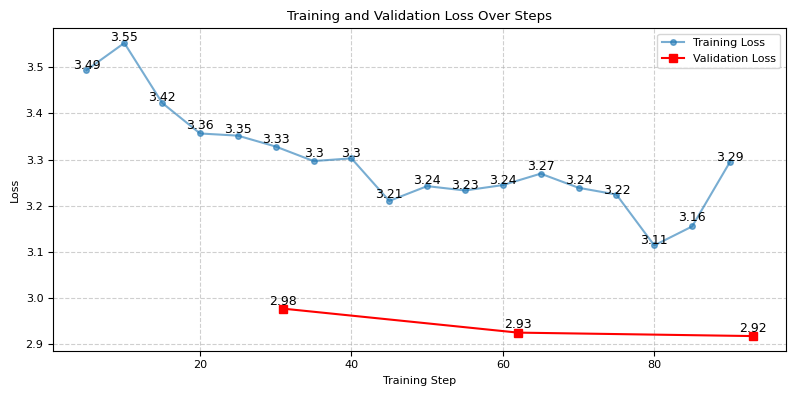

In [ ]:
# --- Plot training & validation loss curves
log_history_df = pd.DataFrame(trainer.state.log_history)
train_loss_df = log_history_df.dropna(subset = ['loss'])      # Keeps only rows where `train_loss` is not NaN
eval_loss_df = log_history_df.dropna( subset = ['eval_loss']) # Keeps only rows where `eval_loss` is not NaN
train_loss_df.loc[:, 'step'] = train_loss_df.loc[:, 'step'].astype(int) # Change any float to int
eval_loss_df.loc[:, 'step'] = eval_loss_df.loc[:, 'step'].astype(int)

# Line Plot
plt.figure(figsize=(8, 4))

# Plot Training Loss
plt.plot(
    train_loss_df['step'],
    train_loss_df['loss'],
    label='Training Loss',
    marker='o',
    linestyle='-',
    alpha=0.6,
    markersize=4)

for xi, yi in zip(train_loss_df['step'], train_loss_df['loss']):
  xi, yi = round(xi, 2), round(yi, 2)
  plt.text(xi, yi, f'{yi}', ha='center', va='bottom', fontsize = 9, color = 'black')

# Plot Validation Loss
plt.plot(
    eval_loss_df['step'],
    eval_loss_df['eval_loss'],
    label='Validation Loss',
    marker='s',
    linestyle='-',
    color='red')

for xi, yi in zip(eval_loss_df['step'],eval_loss_df['eval_loss']):
  xi, yi = round(xi, 2), round(yi, 2)
  plt.text(xi, yi, f'{yi}', ha='center', va='bottom', fontsize = 9, color = 'black')

# Add title and labels
plt.title('Training and Validation Loss Over Steps')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

In [ ]:
trainer.save_model("./fine-tuned_Flan-T5-Small")

In [ ]:
# Save fine tuned model
from huggingface_hub import login
from google.colab import userdata
from huggingface_hub import create_repo
from huggingface_hub import upload_folder
hftoken = userdata.get('HF_TOKEN')
login(token=hftoken)
repo_id = "amiraghhh/fine-tuned-flan-t5-small"
create_repo(repo_id, exist_ok=True)
upload_folder(
    folder_path="./fine-tuned_Flan-T5-Small",
    repo_id = repo_id,
    commit_message="Upload fine-tuned Flan-T5-Small model"
)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...5-Small/model.safetensors:   0%|          | 11.6kB /  308MB            

  ...lan-T5-Small/spiece.model: 100%|##########|  792kB /  792kB            

  ...5-Small/training_args.bin:   1%|1         |  83.0B / 5.97kB            

CommitInfo(commit_url='https://huggingface.co/amiraghhh/fine-tuned-flan-t5-small/commit/e527dabf575518f132633697c6f9c647fbd4010e', commit_message='Upload fine-tuned Flan-T5-Small model', commit_description='', oid='e527dabf575518f132633697c6f9c647fbd4010e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/amiraghhh/fine-tuned-flan-t5-small', endpoint='https://huggingface.co', repo_type='model', repo_id='amiraghhh/fine-tuned-flan-t5-small'), pr_revision=None, pr_num=None)

## **2.4 Generator**

In [ ]:
import torch

# load fine tuned model
ft_model_id = "amiraghhh/fine-tuned-flan-t5-small"
ft_tokenizer = AutoTokenizer.from_pretrained(ft_model_id)
ft_model = AutoModelForSeq2SeqLM.from_pretrained(ft_model_id)

finetuned_llm = pipeline(
    "text2text-generation",
    model = ft_model,       #./fine-tuned_Flan-T5
    tokenizer = ft_tokenizer,
    decoder_start_token_id = flant5model.config.pad_token_id)

def refineResponse(answer):
    """Clean and format generated response text.
    Returns: str(refined_sentences)"""
    # Replace multiple periods with a single period and space
    answer = re.sub(r'\.{2,}', '.', answer)
    answer = re.sub(r'\.([^\s])', r'. \1', answer)

    # If the string does not end with punctuation, find the last one and truncate.
    if not answer.strip().endswith(('.', '!', '?')):
        last_punc_pos = max(answer.rfind('.'), answer.rfind('!'), answer.rfind('?'))
        if last_punc_pos != -1: # Found a punctuation
            answer = answer[:last_punc_pos + 1]

    # Capitalize the first letter of each sentence
    sentences = re.split(r'([.!?]\s*)', answer)
    refined_sentences = []
    for i in range(0, len(sentences), 2):
        sentence_part = sentences[i].strip()
        if sentence_part:
            refined_sentences.append(sentence_part.capitalize())
        if i + 1 < len(sentences):
            refined_sentences.append(sentences[i + 1])

    refined_sentences = ''.join(refined_sentences).strip()

    # Join and clean up extra spaces
    return refined_sentences


def generator(user_query, top_k = 5, detail = False, to_eval = False):
    """Generate answer using pipeline
    Returns
        answer (str) if detail=False
        (answer, contexts) tuple if detail=True
    """

    # 1. Retrieve context, which auto rewrites as well
    try:
        contexts = retriever(user_query, top_k, detail = detail)
        if not contexts:
            # Return a dictionary with empty values if no contexts found during evaluation
            if to_eval:
                return {"answer": "Couldn't find relevant information to answer your question.", "contexts": []}
            else:
                return "Couldn't find relevant information to answer your question."
    except Exception as e:
        error_msg = f"Error retrieving context for '{user_query}': {e}"
        print(error_msg)
        traceback.print_exc()
        if to_eval: # If in evaluation mode, return a dictionary with error message and empty contexts
            return {"answer": error_msg, "contexts": []}
        else:
            return error_msg

    # 2. Build prompt
    try:
        # Pass user_query directly, as it's already rewritten in retriever()
        prompt = buildPrompt(user_query, contexts, user_query)
        #print(f"DEBUG: Generated prompt length: {len(prompt)} chars")
    except Exception as e:
        error_msg = f"Error building prompt: {e}"
        print(error_msg)
        traceback.print_exc()
        if to_eval: # If in evaluation mode, return a dictionary with error message and contexts (even if prompt building failed)
            return {"answer": error_msg, "contexts": contexts} # Or an empty dictionary {}
        else:
            return error_msg

    # 3. Generate response
    try:
        result = finetuned_llm(
            prompt,
            max_new_tokens = 70,       # Reduced tokens to encourage conciseness
            num_beams = 3,
            early_stopping = True,
            do_sample = False,         # Deterministic for medical QA
            repetition_penalty = 2.0,  # Increased penalty to reduce repetition
            eos_token_id = finetuned_llm.tokenizer.eos_token_id # Model stops generating when EOS token produced
            )
        answer = result[0]['generated_text'].strip()
        answer = refineResponse(answer)

    except Exception as e:
        error_msg = f"Error generating response: {e}"
        print(error_msg)
        traceback.print_exc()
        if to_eval: # If in evaluation mode, return a dictionary with error message and contexts
            return {"answer": error_msg, "contexts": contexts} # Or an empty dictionary {}
        else:
            return error_msg

    # 5. Display context details if True
    if detail:
      print(answer)
      print("="*80)
      print("\nCONTEXT SOURCES:")
      for i, ctx in enumerate(contexts, start=1):
          print(f"\n[C{i}]")
          print(f"  Score: {ctx.get('rerank_score', 'N/A')}")
          print(f"  Source Question: {ctx.get('question', 'N/A')}")
          print(f"  Focus Area: {ctx.get('focus_area', 'N/A')}")
          print(f"  Chunk: {ctx['chunk_answer'][:200]}....")  # First 200 chars
      print("="*80)

    if to_eval:
      return {"answer": answer, "contexts": contexts}
    else:
      return answer

Device set to use cuda:0


In [ ]:
def rag(user_query, detail = False):
  """Retrieve context and generate answer for user query.

  Returns: str(generated_answer)"""
  # 1. Generate the initial answer using the RAG pipeline
  generated_answer = generator(user_query, detail = detail)

  # 1. INPUT GUARDRAIL (Fast)
  #emergency_keywords = ["pain", "emergency", "blind", "hurt"]
  #if any(k in user_query.lower() for k in emergency_keywords):
      #return "It sounds like you are in pain. Please contact these emergency resources..."

  # 2. CORE GENERATION (Your existing flow)
  # (Retrieve context, build prompt, run FLAN-T5)
  #raw_answer = generator(query)

  # 3. VERIFICATION LAYER (The "Pretty Up")
  # Use a generic instruction model or simple heuristics
  #if ".." in raw_answer or len(raw_answer) > 500:
      #clean_answer = clean_up_text(raw_answer) # specialized function
  #else:
      #clean_answer = raw_answer

  return generated_answer

## **2.5 Example RAG Output**

query, the retrieved context, and the generated
answer to demonstrate your system.

In [ ]:
# test retrieval
retriever("What is diabetes like? ", top_k = 5, detail = True)

[{'chunk_id': '39_0',
  'chunk_answer': 'What is (are) Causes of Diabetes ? diabetes is a complex group of diseases with a variety of causes. diabetes is a disorder of metabolismthe way the body uses digested food for energy. the digestive tract breaks down carbohydratessugars and starches found in many foodsinto glucose, a form of sugar that enters the bloodstream. with the help of the hormone insulin, cells throughout the body absorb glucose and use it for energy. diabetes develops when the body doesnt make enough insulin or is not able to use insulin effectively, or both. insulin is made in the pancreas, an organ located behind the stomach. beta cells within the islets make insulin and release it',
  'question': 'What is (are) Causes of Diabetes ?',
  'focus_area': 'Causes of Diabetes',
  'rerank_score': 0.306,
  'chroma_distance': 0.543},
 {'chunk_id': '78_1',
  'chunk_answer': 'What causes Diabetes ? of diabetesis caused by a combination of factors, including insulin resistance, a

In [ ]:
# test generator
generator("What is diabetes like? ", top_k = 5, detail = True)

Diabetes is a complex group of diseases with a variety of causes

CONTEXT SOURCES:

[C1]
  Score: 0.306
  Source Question: What is (are) Causes of Diabetes ?
  Focus Area: Causes of Diabetes
  Chunk: What is (are) Causes of Diabetes ? diabetes is a complex group of diseases with a variety of causes. diabetes is a disorder of metabolismthe way the body uses digested food for energy. the digestive t....

[C2]
  Score: -3.399
  Source Question: What causes Diabetes ?
  Focus Area: Diabetes
  Chunk: What causes Diabetes ? of diabetesis caused by a combination of factors, including insulin resistance, a condition in which the bodys muscle, fat, and liver cells do not use insulin effectively. type ....

[C3]
  Score: -4.376
  Source Question: What is (are) Causes of Diabetes ?
  Focus Area: Causes of Diabetes
  Chunk: What is (are) Causes of Diabetes ? an organ located behind the stomach. beta cells within the islets make insulin and release it into the blood. if beta cells dont produce enou

'Diabetes is a complex group of diseases with a variety of causes'

In [ ]:
# rag
rag("What is diabetes like? ", detail = True)

Diabetes is a complex group of diseases with a variety of causes

CONTEXT SOURCES:

[C1]
  Score: 0.306
  Source Question: What is (are) Causes of Diabetes ?
  Focus Area: Causes of Diabetes
  Chunk: What is (are) Causes of Diabetes ? diabetes is a complex group of diseases with a variety of causes. diabetes is a disorder of metabolismthe way the body uses digested food for energy. the digestive t....

[C2]
  Score: -3.399
  Source Question: What causes Diabetes ?
  Focus Area: Diabetes
  Chunk: What causes Diabetes ? of diabetesis caused by a combination of factors, including insulin resistance, a condition in which the bodys muscle, fat, and liver cells do not use insulin effectively. type ....

[C3]
  Score: -4.376
  Source Question: What is (are) Causes of Diabetes ?
  Focus Area: Causes of Diabetes
  Chunk: What is (are) Causes of Diabetes ? an organ located behind the stomach. beta cells within the islets make insulin and release it into the blood. if beta cells dont produce enou

'Diabetes is a complex group of diseases with a variety of causes'

# **3. Evaluation and Analysis:**

Evaluate your RAG system on a small set of
representative test questions using both quantitative and qualitative
measures.


Systematic Analysis of Retrieval-Augmented Generation-Based LLMs for Medical Chatbot Applications

## **3.1 Retrieval Evaluation**

### Set up `buildGroudTruth`, `evaluateRetrievalByQuestion`, `retrieveWithoutRewritter`

In [ ]:
def buildGroundTruth(chunks):
    """Retrieves ground truth
    Returns: list(ground_truth)"""
    ground_truth = {}
    for chunk in chunks:
        qid = chunk['question_id']
        if qid not in ground_truth:
            ground_truth[qid] = set()
        ground_truth[qid].add(chunk['chunk_id'])
    return ground_truth

In [ ]:
def evaluateRetrievalByQuestion(chunks, retriever, ground_truth, k=5, debug=False):
    """Evaluate retrieval quality using precision, recall, and MRR metrics.
    Returns: None"""
    unique_questions = {}
    for c in chunks:
        unique_questions[c['question_id']] = c['question']

    # 1. Initialize Score lists
    p1_scores = []
    p3_scores = []
    recall_scores = []
    mrr_scores = []

    debug_count = 0
    debug_limit = 3

    print(f"Evaluating {len(unique_questions)} unique questions...\n")

    # 2. Loop over each chunk
    for qid, question_text in unique_questions.items():

        show_debug = debug and (debug_count < debug_limit)

        if show_debug:
            print(f"Question ID: {qid}")
            print(f"Question:    {question_text}")

        # 3. Run Retrieval
        retrieved_contexts = retriever(q = question_text, top_k=k)

        gt = ground_truth.get(qid, set())

        if show_debug:
            print(f"Ground Truth IDs: {sorted(list(gt))}")

        # 4. Calculate Metrics per Query
        # 4A. Get Relevance List (for top k)
        relevant_matches = []
        for rank, context in enumerate(retrieved_contexts[:k], 1):
            r_id = context['chunk_id']
            is_rel = r_id in gt
            relevant_matches.append(is_rel)

            if show_debug:
                status = '✓ RELEVANT' if is_rel else '✗'
                print(f"    {rank}. {r_id} - {status}")

        # 4B. Precision@1
        p1 = 1.0 if relevant_matches and relevant_matches[0] else 0.0
        p1_scores.append(p1)

        # 4C. Precision@3
        relevant_in_top_3 = sum(1 for is_rel in relevant_matches[:3] if is_rel)
        p3 = relevant_in_top_3 / 3.0
        p3_scores.append(p3)

        # 4D. Recall@k
        relevant_in_top_k = sum(1 for is_rel in relevant_matches if is_rel) # Avoid division by zero if GT is empty
        recall = relevant_in_top_k / len(gt) if len(gt) > 0 else 0.0
        recall_scores.append(recall)

        # 4E. MRR
        reciprocal_rank = 0.0
        for i, is_rel in enumerate(relevant_matches):
            if is_rel:
                rank = i + 1
                reciprocal_rank = 1 / rank
                break
        mrr_scores.append(reciprocal_rank)

        if show_debug:
            print(f"\nSCORES for QID {qid}:")
            print(f"    P@1:    {p1:.2f}")
            print(f"    P@3:    {p3:.2f}")
            print(f"    Recall: {recall:.2f}")
            print(f"    MRR:    {reciprocal_rank:.2f}")
            print("=" * 80)
            debug_count += 1

    # 5. Aggregate Results
    def get_mean(scores):
        return sum(scores) / len(scores) if scores else 0.0

    results = {
        'mean_p@1': get_mean(p1_scores),
        'mean_p@3': get_mean(p3_scores),
        'mean_recall': get_mean(recall_scores),
        'mean_mrr': get_mean(mrr_scores)
    }

    print("\nEvaluation Complete.")
    print("-" * 80)
    for metric, score in results.items():
        print(f"{metric}: {score:.4f}")
    print("-" * 80)

    return results

In [ ]:
def retrieverWithoutRewriter(q, top_k = 5, detail = False):
  """Retrieve relevant context chunks for a query without rewritting it.
  Returns: list(contexts)"""

  # 1. Embed the original query
  q_embed = embed_model.encode([q]).tolist() # .tolist() because chromadb expects lists, not numpy arrays

  # 2. Search for similar vectors in chromadb
  search_result = vector_store.query(
      query_embeddings = q_embed,
      n_results = max(5, top_k * 2))  # At least 10 or 2x what user wants
  if not search_result['documents'][0]:
      return []  # or raise exception

  # 3. Format search results
  retrieved_chunks = search_result['documents'][0]
  retrieved_metas = search_result['metadatas'][0]
  retrieved_ids = search_result['ids'][0] # Get the chunk_ids here
  retrieved_distances = search_result.get('distances', [[]])[0]

  # 4. Rerank
  rerank_scores = getMonoT5Scores(q, retrieved_chunks)
  if len(rerank_scores) != len(retrieved_chunks):
      raise ValueError("Rerank scores mismatch chunk count")

  # 5. Map score with their data
  candidates = []
  for r in range(len(retrieved_chunks)):
    candidates.append({
      'chunk_id': retrieved_ids[r],
      'chunk_answer': retrieved_chunks[r],
      'question': retrieved_metas[r]['question'],
      'focus_area': retrieved_metas[r]['focus_area'],
      'chroma_dist': retrieved_distances[r],
      'rerank_score': rerank_scores[r]
    })

  # 6. Sort high to low scores
  candidates.sort(key = lambda s:s['rerank_score'], reverse = True)
  sorted_results = candidates[:top_k]

  # 7. Combine needed items into `contexts` dictionary
  contexts = []
  for i in sorted_results:
      item = {
          'chunk_id': i['chunk_id'], # Ensure chunk_id is always present
          'chunk_answer': i['chunk_answer'],
          'question': i['question']
      }
      if detail:
          item['focus_area'] = i['focus_area']
          item['rerank_score'] = round(i['rerank_score'], 3)
          item['chroma_distance'] = round(i['chroma_dist'], 3)
      contexts.append(item)

  return contexts

In [ ]:
 def retrieverWithoutReranker(q, top_k = 5, detail = False):
    """Retrieve relevant context chunks for a query.
    Returns: list(contexts)"""

    # 1. Embed the rewritten query
    q_rewritten = rewrite_query(q)
    q_embed = embed_model.encode([q_rewritten]).tolist()
    if not q_rewritten or q_rewritten.strip() == "":
        raise ValueError("Query rewrite returned empty string")

    # 2. Search for similar vectors in chromadb
    search_result = vector_store.query(
        query_embeddings = q_embed,
        n_results = 10
    )
    if not search_result['documents'][0]:
        return []  # or raise exception

    # 3. Combine needed items into `contexts` dictionary directly from search_result
    contexts = []
    for r in range(len(search_result['ids'][0])):
        item = {
            'chunk_id': search_result['ids'][0][r],
            'chunk_answer': search_result['documents'][0][r],
            'question': search_result['metadatas'][0][r]['question']
        }
        if detail:
            item['focus_area'] = search_result['metadatas'][0][r]['focus_area']
            # No rerank_score in this version
            item['chroma_distance'] = round(search_result['distances'][0][r], 3)
        contexts.append(item)

    return contexts

### Run Tests

In [ ]:
# Evaluate on Train set
train_ground_truth = buildGroundTruth(train_chunks)
evaluateRetrievalByQuestion(train_chunks, retriever, train_ground_truth, k = 3, debug = True)

Evaluating 495 unique questions...

Question ID: 0
Question:    What are the symptoms of Breast Cancer ?
Ground Truth IDs: ['0_0', '0_1', '0_2']
    1. 0_2 - ✓ RELEVANT
    2. 0_1 - ✓ RELEVANT
    3. 0_0 - ✓ RELEVANT

SCORES for QID 0:
    P@1:    1.00
    P@3:    1.00
    Recall: 1.00
    MRR:    1.00
Question ID: 1
Question:    what research (or clinical trials) is being done for Breast Cancer ?
Ground Truth IDs: ['1_0', '1_1', '1_2', '1_3', '1_4', '1_5']
    1. 3_23 - ✗
    2. 1_2 - ✓ RELEVANT
    3. 1_1 - ✓ RELEVANT

SCORES for QID 1:
    P@1:    0.00
    P@3:    0.67
    Recall: 0.33
    MRR:    0.50
Question ID: 2
Question:    What are the treatments for Breast Cancer ?
Ground Truth IDs: ['2_0', '2_1', '2_2', '2_3', '2_4', '2_5', '2_6', '2_7']
    1. 2_0 - ✓ RELEVANT
    2. 2_5 - ✓ RELEVANT
    3. 2_3 - ✓ RELEVANT

SCORES for QID 2:
    P@1:    1.00
    P@3:    1.00
    Recall: 0.38
    MRR:    1.00

Evaluation Complete.
-----------------------------------------------------------

{'mean_p@1': 0.18585858585858586,
 'mean_p@3': 0.19393939393939394,
 'mean_recall': 0.21195618124044804,
 'mean_mrr': 0.2606060606060606}

In [ ]:
# Evaluate on Train set but without query rewriting
train_ground_truth = buildGroundTruth(train_chunks)
evaluateRetrievalByQuestion(train_chunks, retrieverWithoutRewriter, train_ground_truth, k = 3, debug = True)

Evaluating 495 unique questions...

Question ID: 0
Question:    What are the symptoms of Breast Cancer ?
Ground Truth IDs: ['0_0', '0_1', '0_2']
    1. 0_2 - ✓ RELEVANT
    2. 0_1 - ✓ RELEVANT
    3. 0_0 - ✓ RELEVANT

SCORES for QID 0:
    P@1:    1.00
    P@3:    1.00
    Recall: 1.00
    MRR:    1.00
Question ID: 1
Question:    what research (or clinical trials) is being done for Breast Cancer ?
Ground Truth IDs: ['1_0', '1_1', '1_2', '1_3', '1_4', '1_5']
    1. 3_23 - ✗
    2. 1_0 - ✓ RELEVANT
    3. 1_1 - ✓ RELEVANT

SCORES for QID 1:
    P@1:    0.00
    P@3:    0.67
    Recall: 0.33
    MRR:    0.50
Question ID: 2
Question:    What are the treatments for Breast Cancer ?
Ground Truth IDs: ['2_0', '2_1', '2_2', '2_3', '2_4', '2_5', '2_6', '2_7']
    1. 2_0 - ✓ RELEVANT
    2. 2_5 - ✓ RELEVANT
    3. 2_6 - ✓ RELEVANT

SCORES for QID 2:
    P@1:    1.00
    P@3:    1.00
    Recall: 0.38
    MRR:    1.00

Evaluation Complete.
-----------------------------------------------------------

{'mean_p@1': 0.21818181818181817,
 'mean_p@3': 0.2868686868686869,
 'mean_recall': 0.2883831661522815,
 'mean_mrr': 0.32727272727272727}

In [ ]:
# Evaluate on Train set but without context reranking
train_ground_truth = buildGroundTruth(train_chunks)
evaluateRetrievalByQuestion(train_chunks, retrieverWithoutReranker, train_ground_truth, k = 3, debug = True)

Evaluating 495 unique questions...

Question ID: 0
Question:    What are the symptoms of Breast Cancer ?
Ground Truth IDs: ['0_0', '0_1', '0_2']
    1. 0_0 - ✓ RELEVANT
    2. 0_1 - ✓ RELEVANT
    3. 0_2 - ✓ RELEVANT

SCORES for QID 0:
    P@1:    1.00
    P@3:    1.00
    Recall: 1.00
    MRR:    1.00
Question ID: 1
Question:    what research (or clinical trials) is being done for Breast Cancer ?
Ground Truth IDs: ['1_0', '1_1', '1_2', '1_3', '1_4', '1_5']
    1. 1_5 - ✓ RELEVANT
    2. 1_0 - ✓ RELEVANT
    3. 1_3 - ✓ RELEVANT

SCORES for QID 1:
    P@1:    1.00
    P@3:    1.00
    Recall: 0.50
    MRR:    1.00
Question ID: 2
Question:    What are the treatments for Breast Cancer ?
Ground Truth IDs: ['2_0', '2_1', '2_2', '2_3', '2_4', '2_5', '2_6', '2_7']
    1. 2_1 - ✓ RELEVANT
    2. 2_4 - ✓ RELEVANT
    3. 2_5 - ✓ RELEVANT

SCORES for QID 2:
    P@1:    1.00
    P@3:    1.00
    Recall: 0.38
    MRR:    1.00

Evaluation Complete.
---------------------------------------------------

{'mean_p@1': 0.7797979797979798,
 'mean_p@3': 0.5265993265993266,
 'mean_recall': 0.6978469291008929,
 'mean_mrr': 0.8188552188552188}

In [ ]:
# neither rewriter nor reranker


## **3.2 Full RAG Evaluation**

In [ ]:
def evaluateRAG(test_chunks, test_data, split_name = "test", generator_func = generator, retriever_func = retriever, top_k = 3, sample_size = None, debug = False):
    """
    Evaluate full RAG system (retriever + generator) on test chunks.
    Uses end-to-end answer quality metrics without LLM judge.
    Returns: dict(results)
    """

    # 1. Build Ground Truth mapping
    ground_truth = buildGroundTruth(test_chunks)

    # 2. Handle sampling if dataset is large
    if sample_size and len(test_chunks) > sample_size:
        sample_indices = np.random.choice(len(test_chunks), sample_size, replace=False)
        eval_chunks = [test_chunks[i] for i in sample_indices]
        print(f"Sampling {sample_size}/{len(test_chunks)} chunks for evaluation...")
    else:
        eval_chunks = test_chunks

    # 3. Initialize metrics dictionaries
    metrics = {
        'sbert_similarity': [],
        'nass_score': [],
        'hallucination_rate': [],
        'context_relevance': [],
        'chunk_topic_match': [],
        'retrieval_precision': [],
        'retrieval_recall': [],
    }

    unique_questions = {}
    debug_count = 0
    debug_limit = 3 if debug else 0
    print(f"{'-'*20} EVALUATING RAG ON {split_name.upper()} SET ({len(eval_chunks)} chunks) {'-'*20}")
    print("-"*80)

    # 4. Process each chunk in the test set
    for idx, chunk in enumerate(eval_chunks):
        query = chunk['question']
        gt_answer = chunk['chunk_answer']
        gt_topic = chunk['focus_area']
        question_id = chunk['question_id']

        # 5. Get ground truth chunk IDs for this question (NEW)
        gt_chunk_ids = ground_truth.get(question_id, set())

        # 6. Track unique questions to see how many we're evaluating
        if question_id not in unique_questions:
            unique_questions[question_id] = query

        try:
            # 7. Run Retrieval
            retrieved_data = retriever_func(q = query, top_k = top_k, detail = True)
            if not retrieved_data:
                print(f"No retrieval results for question {question_id}")
                continue

            # Get retrieved chunk IDs
            retrieved_chunk_ids = set(item.get('chunk_id') for item in retrieved_data if 'chunk_id' in item)

            # Get retrieved context
            context_text = " ".join([item.get('chunk_answer', '') for item in retrieved_data])
            retrieved_topics = [item.get('focus_area', '') for item in retrieved_data]

            # 8. Run Generator
            generated_answer = generator_func(query)

            if not generated_answer or generated_answer.strip() == "":
                print(f"  Warning: Generator returned empty for question {question_id}")
                continue

            # 9. Calculate Metrics
            # 9A. SBERT Cosine Similarity
            embeddings = embed_model.encode([generated_answer, gt_answer])
            sb_cs = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
            metrics['sbert_similarity'].append(sb_cs)

            # 9B. Negation-Aware Semantic Similarity (NASS)
            negations = ['not ', ' no ', "n't ", 'never ', 'none ']
            has_neg_gen = any(n in generated_answer.lower() for n in negations)
            has_neg_gt = any(n in gt_answer.lower() for n in negations)
            if has_neg_gen == has_neg_gt:
                nass = sb_cs  # Same negation status → use SBERT score
            else:
                nass = sb_cs * 0.5  # Opposite negation → penalize heavily
            metrics['nass_score'].append(nass)

            # 9C. Hallucination Rate
            STOP_WORDS = {'the', 'a', 'an', 'is', 'are', 'was', 'to', 'of', 'in', 'and', 'by', 'with', 'for'}
            gen_words = set(w for w in generated_answer.lower().split() if w not in STOP_WORDS and len(w) > 2)
            context_words = set(w for w in context_text.lower().split() if w not in STOP_WORDS and len(w) > 2)
            if gen_words:
                supported_words = len(gen_words.intersection(context_words))
                support_ratio = supported_words / len(gen_words)
                hallucination = 1.0 - support_ratio  # Higher = more hallucinated
            else:
                hallucination = 1.0 if not generated_answer else 0.0
            metrics['hallucination_rate'].append(hallucination)

            # 9D. Context Relevance
            q_words = set(w for w in query.lower().split() if len(w) > 2)

            if q_words:
                matching_words = len(q_words.intersection(context_words))
                context_relevance = matching_words / len(q_words)
            else:
                context_relevance = 0.0

            metrics['context_relevance'].append(context_relevance)

            # 9E. Topic Match
            topic_matches = sum(1 for rt in retrieved_topics if rt == gt_topic)
            topic_match_pct = topic_matches / len(retrieved_topics) if retrieved_topics else 0.0
            metrics['chunk_topic_match'].append(topic_match_pct)

            # 9F. Retrieval Precision
            if retrieved_chunk_ids:
                correct_retrievals = len(retrieved_chunk_ids.intersection(gt_chunk_ids))
                precision = correct_retrievals / len(retrieved_chunk_ids)
            else:
                precision = 0.0
            metrics['retrieval_precision'].append(precision)

            # 9G. Retrieval Recall
            if gt_chunk_ids:
                recall = len(retrieved_chunk_ids.intersection(gt_chunk_ids)) / len(gt_chunk_ids)
            else:
                recall = 0.0
            metrics['retrieval_recall'].append(recall)

            # 10. Debug
            if idx < debug_limit:
                print(f"Question ID {question_id}")
                print(f"Question:   {query[:70]}...")
                print(f"  Topic:        {gt_topic}")
                print(f"  Generated:    {generated_answer[:100]}...")
                print(f"  Ground Truth: {gt_answer[:100]}...")
                print(f"  ─────────────────────────────")
                print(f"  SBERT Similarity:    {sb_cs:.3f}")
                print(f"  NASS Score:          {nass:.3f}")
                print(f"  Hallucination ↓:     {hallucination:.3f}")
                print(f"  Context Relevance:   {context_relevance:.3f}")
                print(f"  Topic Match:         {topic_match_pct:.1%}")
                print(f"  Retrieval Precision: {precision:.3f} ({correct_retrievals}/{len(retrieved_chunk_ids)})")
                print(f"  Retrieval Recall:    {recall:.3f}")
                print()

        except Exception as e:
            print(f"  Error processing chunk {idx}: {e}")
            continue

    # 11. Aggregate Results
    results = {
        'split': split_name,
        'num_chunks_evaluated': len(eval_chunks),
        'num_unique_questions': len(unique_questions),
    }

    for metric_name, scores in metrics.items():
        if scores:
            results[f'{metric_name}_mean'] = np.mean(scores)
            results[f'{metric_name}_std'] = np.std(scores)
            results[f'{metric_name}_min'] = np.min(scores)
            results[f'{metric_name}_max'] = np.max(scores)
        else:
            results[f'{metric_name}_mean'] = 0.0

    # 12. Print Summary
    print(f"{'='*80}")
    print(f"{' '*25} EVALUATION SUMMARY: {split_name.upper()}{' '*25}")
    print(f"{'='*80}")
    print(f"Chunks evaluated:      {len(eval_chunks)}")
    print(f"Unique questions:      {len(unique_questions)}\n")

    print("GENERATED ANSWER QUALITY METRICS:")
    print(f"  SBERT Similarity:      {results['sbert_similarity_mean']:.4f} (±{results['sbert_similarity_std']:.4f})")
    print(f"  NASS Score:            {results['nass_score_mean']:.4f} (±{results['nass_score_std']:.4f})")
    print(f"  Hallucination Rate ↓:  {results['hallucination_rate_mean']:.4f} (±{results['hallucination_rate_std']:.4f})")

    print("\nRETRIEVAL QUALITY METRICS:")
    print(f"  Context Relevance:     {results['context_relevance_mean']:.4f}")
    print(f"  Topic Match %:         {results['chunk_topic_match_mean']:.1%}")
    print(f"  Retrieval Precision:   {results['retrieval_precision_mean']:.4f}")  # NEW
    print(f"  Retrieval Recall:      {results['retrieval_recall_mean']:.4f}")     # NEW

    return results

In [ ]:
from datetime import datetime

In [ ]:
print("Starting full RAG evaluation across splits...")
print("Start Time:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# Evaluate on Train Split
train_results = evaluateRAG(
    test_chunks = train_chunks,
    test_data = train_data,
    split_name = "train",
    generator_func = generator,
    top_k = 5,
    sample_size = 50,  # Reduce to 50 for speed; remove this for full eval
    debug = True
)
print("train_data evaluation complete.")
print("Checkpoint time:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# Evaluate on Validation Split
val_results = evaluateRAG(
    test_chunks = val_chunks,
    test_data = val_data,
    split_name = "validation",
    generator_func = generator,
    top_k = 5,
    sample_size = 50,
    debug = False
)
print("val_data evaluation complete.")
print("Checkpoint time:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# Evaluate on Test Split
test_results = evaluateRAG(
    test_chunks = test_chunks,
    test_data = test_data,
    split_name = "test",
    generator_func = generator,
    top_k = 5,
    sample_size = 50,
    debug = False
)
print("test_data evaluation complete.")
print("Checkpoint time:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# Cross-Split Comparison
print("\n" + "="*100)
print("CROSS-SPLIT COMPARISON")
print("="*100)

comparison_df = pd.DataFrame({
    'Train': train_results,
    'Validation': val_results,
    'Test': test_results
}).T

# Select only the _mean metrics for cleaner comparison
mean_cols = [col for col in comparison_df.columns if '_mean' in col]
comparison_df_means = comparison_df[mean_cols].round(4)
comparison_df_means.columns = [col.replace('_mean', '') for col in comparison_df_means.columns]

print("\nKey Metrics (Mean values):")
print(comparison_df_means)

print("End Time:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Starting full RAG evaluation across splits...
Start Time: 2025-12-23 03:42:55
Sampling 50/1574 chunks for evaluation...
-------------------- EVALUATING RAG ON TRAIN SET (50 chunks) --------------------
--------------------------------------------------------------------------------
Question ID 5
Question:   What are the stages of Breast Cancer ?...
  Topic:        Breast Cancer
  Generated:    What are the stages of breast cancer?...
  Ground Truth: lymph vessels to other parts of the body. blood. the cancer spreads from where it began by getting i...
  ─────────────────────────────
  SBERT Similarity:    0.379
  NASS Score:          0.379
  Hallucination ↓:     0.250
  Context Relevance:   0.667
  Topic Match:         100.0%
  Retrieval Precision: 1.000 (5/5)
  Retrieval Recall:    0.294

Question ID 482
Question:   How many people are affected by Langerhans cell histiocytosis ?...
  Topic:        Langerhans cell histiocytosis
  Generated:    None of the above choices....
  Ground Tru

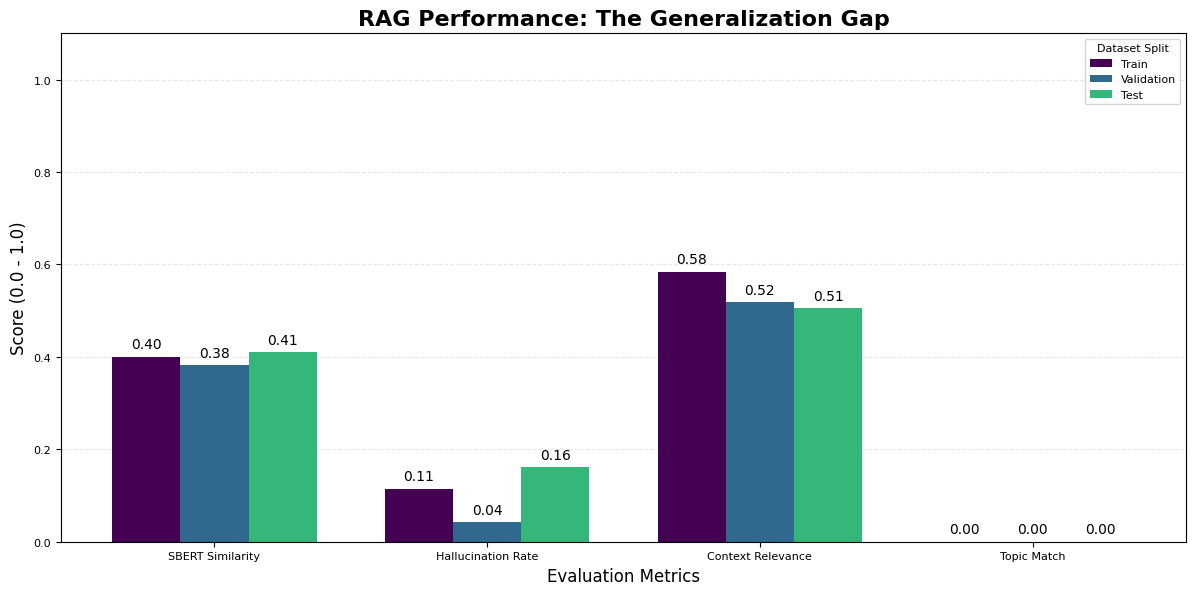

In [ ]:
# 1. Extract data from comparison_df_means
metrics_to_plot = ['sbert_similarity', 'hallucination_rate', 'context_relevance', 'chunk_topic_match']

# Filter and transpose the dataframe
df_plot = comparison_df_means[metrics_to_plot].T

# Rename index for better display
metric_display_names = {
    'sbert_similarity': 'SBERT Similarity',
    'hallucination_rate': 'Hallucination Rate',
    'context_relevance': 'Context Relevance',
    'chunk_topic_match': 'Topic Match'
}
df_plot.index = df_plot.index.map(metric_display_names)

# Reset index to create 'Metric' column
df_plot = df_plot.reset_index()
df_plot.columns = ['Metric', 'Train', 'Validation', 'Test']

# 2. Prepare data for matplotlib
metrics = df_plot['Metric'].values
train_scores = df_plot['Train'].values
val_scores = df_plot['Validation'].values
test_scores = df_plot['Test'].values

# 3. Set up the bar positions
x = np.arange(len(metrics))  # Label locations
width = 0.25  # Width of bars

# 4. Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create bars
bars1 = ax.bar(x - width, train_scores, width, label='Train', color='#440154')
bars2 = ax.bar(x, val_scores, width, label='Validation', color='#31688e')
bars3 = ax.bar(x + width, test_scores, width, label='Test', color='#35b779')

# 5. Customization
ax.set_title('RAG Performance: The Generalization Gap', fontsize=16, fontweight='bold')
ax.set_ylabel('Score (0.0 - 1.0)', fontsize=12)
ax.set_xlabel('Evaluation Metrics', fontsize=12)
ax.set_ylim(0, 1.1)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(title='Dataset Split', loc='upper right')
ax.grid(True, axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# 6. Add value labels on top of bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 9),
                    textcoords='offset points',
                    ha='center', va='center',
                    fontsize=10)

plt.tight_layout()
plt.show()

## **3.3 3–5 representative examples**

of your system’s outputs,
covering both successful and problematic cases. For each example,
display the input question, the retrieved document snippets, and the generated answer.



Include, where appropriate, visual representations
of retrieval or answer evaluation
Note: In Component 2 (Reflective Report), comment briefly on each
example’s relevance and factual accuracy, highlighting cases where
the system performs well or fails (e.g., irrelevant retrieval, incomplete
responses, or hallucinated answers).

# **4. Optional extension:**

## **Deploy your RAG system**



as an interactive demo using
Gradio, Streamlit, or another suitable framework. The demo should allow
users to input medical questions and view the generated answers.
Note: You may host the demo on a platform such as Hugging Face Spaces or
run it locally. If hosted on a cloud-hosted platform, include the shareable link
or public URL in your submission report. If run locally, include screenshots in
your report showing the working interface and example as evidence of
successful deployment.

In [ ]:
# Create a Gradio interface to turn the function into a web app
demo = gr.Interface(
    fn = rag,
    inputs = gr.Textbox(lines=5, label="Enter your medical question here"), # Make input box taller
    outputs = gr.Textbox(lines=10, label="Generated Answer"),               # Make output box taller
    title = "Medical QA",                                                   # Title shown at the top of the web app
    description = "Type your query and get a model generated response.",    # Short explanation for the app
    theme = gr.themes.Glass()                                               # Prebuilt gr.theme
)

In [ ]:
demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ec6d68ed6646d46847.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
